Author: Tathagat Saha

Mat no: 902046

## Neural Matrix Factorization 
Till now we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers in this way:
$$\phi^{GMF} = \mathbf{p_u}^G\odot \mathbf{q_i}^G$$
$$\phi^{MLP} = a_L(\mathbf{W}_L^T(a_{L-1}(...a_2 (\mathbf{W}_2^T \begin{bmatrix}
\mathbf{p_u} \\ \mathbf{q_i}
\end{bmatrix} + \mathbf{b}_2)...)) + \mathbf{b}_L)$$

$$ y_{ui} = \sigma(\mathbf{h}^T \begin{bmatrix}
\ \phi^{GMF} \\ \phi^{MLP}
\end{bmatrix})$$

<center>  <img src="https://drive.google.com/uc?export=view&id=1gNLUpiQdbDPMdvfZYVs3lcou3cd4Favb" width="550" height="400"> </center> 

Let's now try to apply transfer learning to such an architecture. 

- TASK 1: Train the GMF and MLP models separately, inspect and save the parameters.
- TASK 2: Use the pre-trained parameters for initializing the NMF architecture. In particular, use the pre-trained embeddings for users and items and the initialized layers of GMF and MLP.
- TASK 3: Finally, train the NMF model both by freezing the layers preceding the NeuMF layer and by keeping all the parameters trainable. Compare the performance with the network trained from scratch.


In [ ]:
%matplotlib inline

import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import argparse
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# set the seed for reproducibility: built-in python, numpy, and pytorch
seed = 20
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [ ]:
device = torch.device('cpu')
#device = torch.device('cuda') # Uncomment this to run on GPU

In [ ]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=42, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=15,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+', 
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng", 
	type=int,
	default=4, 
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", 
	type=int,
	default=100, 
	help="Number of negative samples for test set")
parser.add_argument("--out", 
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

In [ ]:
class GMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        #Added the below Line
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [ ]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [ ]:
class Rating_Datset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Datset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]
		
		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

In [ ]:
class NCF_Data(object):
	"""
	Construct Dataset for NCF
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)

	
	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Datset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
DATA_PATH = 'drive/MyDrive/Colab Notebooks/u.data'
MODEL_PATH = 'drive/MyDrive/Colab Notebooks/2 - Models/movielens_{}/'.format(num_sample_data) #change this with your directory 

args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load data
ml_100k = pd.read_csv(
	DATA_PATH, 
	sep="\t", 
	names = ['user_id', 'item_id', 'rating', 'timestamp'], 
	engine='python')

ml_100k

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [ ]:
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

In [ ]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

In [ ]:
modelGMF = GMF(args, num_users, num_items)
modelMLP = MLP(args,num_users, num_items)
model_dict = {'model1': modelGMF }
model_dict['model2'] = modelMLP
print('Training {} ...'.format(modelGMF))
print('Training {} ...'.format(modelMLP))

Training GMF(
  (embedding_user): Embedding(944, 32)
  (embedding_item): Embedding(1683, 32)
  (affine_output): Linear(in_features=32, out_features=1, bias=True)
  (logistic): Sigmoid()
) ...
Training MLP(
  (embedding_user): Embedding(944, 32)
  (embedding_item): Embedding(1683, 32)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
) ...


In [ ]:
model_dict

In [ ]:
def plot_loss(training_loss, validation_loss):
  plt.plot(range(len(training_loss)), training_loss, c='b', label='Loss Training')
  plt.plot(range(len(validation_loss)), validation_loss, c='r', label='Loss Validation')
  #plt.ylim(0.4, 0.8)
  plt.show()

In [ ]:
# train, evaluation
args = parser.parse_args("")
best_hr = 0
#learning_rate = 0.001 #0.0001

def training_step(net, criterion, optimizer):
    # set the model to train mode
  running_loss=0
  net.train()
  i=0
  for user, item, label in train_loader:
    i = i + 1
    user = user.to(device)
    item = item.to(device)
    label = label.to(device)
    optimizer.zero_grad()
    prediction = net(user, item)
    loss = criterion(prediction, label)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()

  return running_loss/(i)

def validation_step(net, criterion, optimizer):

    running_loss=0
    # set the model to train mode
    net.eval()
    i=0
    for user, item, label in train_loader:
      i=i+1
      user = user.to(device)
      item = item.to(device)
      label = label.to(device)
      with torch.no_grad():
        prediction = net(user, item)
        loss = criterion(prediction, label)
        running_loss+=loss.item()
    return running_loss/(i) 





Training model1 ...


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



 epoch 0
-- train loss 0.183, validation loss 0.161

 epoch 5
-- train loss 0.133, validation loss 0.126

 epoch 10
-- train loss 0.0981, validation loss 0.0945


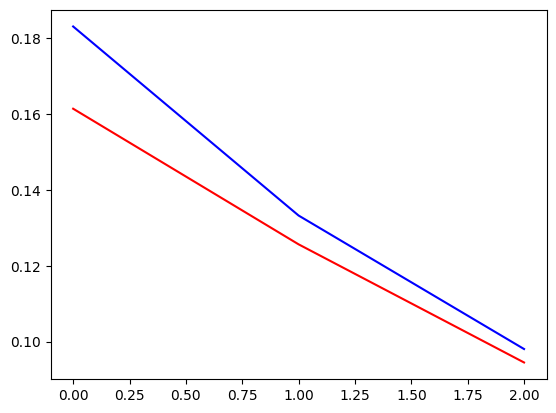

Loss Diff -0.010936615464632931
Training model2 ...

 epoch 0
-- train loss 0.133, validation loss 0.115

 epoch 5
-- train loss 0.108, validation loss 0.105

 epoch 10
-- train loss 0.0944, validation loss 0.0914


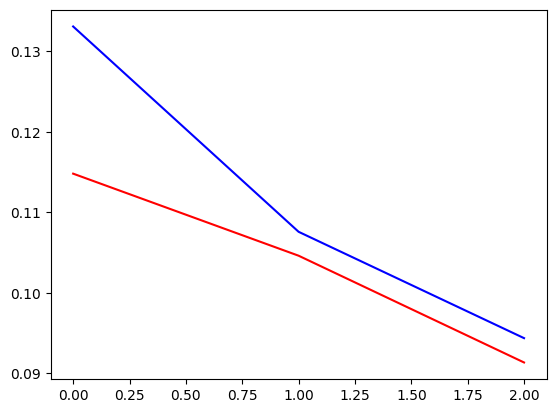

Loss Diff -0.008089033774806955


In [ ]:
#model_dict = {'model': model}
args = parser.parse_args("")


for model in model_dict.keys():
  print('Training {} ...'.format(model))
  criterion = nn.MSELoss(reduction = 'mean')
  optimizer = torch.optim.Adam(model_dict[model].parameters(), lr=args.lr)

  tr_loss, va_loss = [], []

  for epoch in range(args.epochs):
    tr_loss_step = training_step(model_dict[model], criterion = criterion, optimizer = optimizer)
    if epoch % 5 == 0:
      va_loss_step = validation_step(model_dict[model], criterion = criterion, optimizer = optimizer)
      va_loss.append(va_loss_step)
      tr_loss.append(tr_loss_step)
      print(f'\n epoch {epoch}')
      print(f'-- train loss {tr_loss_step:.3}, validation loss {va_loss_step:.3}')

  torch.save(model, 
					'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))
  plot_loss(tr_loss, va_loss)
  loss_diff = np.array(va_loss)- np.array(tr_loss)
  print('Loss Diff', np.mean(loss_diff[-10:]))

In [ ]:
model_dict.keys()-'model'

{'model1', 'model2'}

In [ ]:
args.factor_num

32

In [ ]:


class neuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(neuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_gmf = args.factor_num
        self.factor_num_mlp =  int(args.layers[0]/2)
        self.layers = args.layers

        self.embedding_user_GMF = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_gmf)
        self.embedding_item_GMF = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_gmf)
        
        self.embedding_user_MLP = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_MLP = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=args.layers[-1] + self.factor_num_gmf, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_GMF = self.embedding_user_GMF(user_indices)
        item_embedding_GMF = self.embedding_item_GMF(item_indices)

        user_embedding_MLP = self.embedding_user_MLP(user_indices)
        item_embedding_MLP = self.embedding_item_MLP(item_indices)

        #GMF Layer
        element_product =torch.mul(user_embedding_GMF, item_embedding_GMF)
        
        #NCF/MLP Layer
        vector = torch.cat([user_embedding_MLP, item_embedding_MLP], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        
        #Combined NeuMF Layer
        #x = torch.add(linear_gmf, linear_mlp, alpha=1, out=None)
        x = torch.cat([vector, element_product], dim=-1)
        logits = self.affine_output(x)
        rating = self.logistic(logits)
        return rating.squeeze()
    
    def init_weight(self):
        pass

In [ ]:
new_model = neuMF(args,num_users, num_items)
new_model.to(device)

neuMF(
  (embedding_user_GMF): Embedding(944, 32)
  (embedding_item_GMF): Embedding(1683, 32)
  (embedding_user_MLP): Embedding(944, 32)
  (embedding_item_MLP): Embedding(1683, 32)
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=40, out_features=1, bias=True)
  (logistic): Sigmoid()
)

In [ ]:
transfer_GMF_nof_model = GMF(args,num_users, num_items)
transfer_GMF_f_model = GMF(args,num_users, num_items)
transfer_MLP_nof_model = MLP(args,num_users, num_items)
transfer_MLP_f_model = MLP(args,num_users, num_items)
transfer_neuMF_nof_model = neuMF(args,num_users, num_items)
transfer_neuMF_f_model =  neuMF(args,num_users, num_items)

#model_dicts['transfer_GMF_nof_model']= transfer_GMF_nof_model
#model_dicts['transfer_GMF_f_model']= transfer_GMF_f_model
#model_dicts['transfer_MLP_nof_model']= transfer_MLP_nof_model
#model_dicts['transfer_MLP_f_model']= transfer_MLP_f_model
model_dicts = {'transfer_neuMF_nof_model': transfer_neuMF_nof_model}
model_dicts['transfer_neuMF_f_model']= transfer_neuMF_f_model
#model_dicts['transfer_neuMF_f_model']= transfer_neuMF_f_model
#model_dicts['new_model'] = new_model

In [ ]:
model_dicts

{'transfer_neuMF_nof_model': neuMF(
   (embedding_user_GMF): Embedding(944, 32)
   (embedding_item_GMF): Embedding(1683, 32)
   (embedding_user_MLP): Embedding(944, 32)
   (embedding_item_MLP): Embedding(1683, 32)
   (fc_layers): ModuleList(
     (0): Linear(in_features=64, out_features=32, bias=True)
     (1): Linear(in_features=32, out_features=16, bias=True)
     (2): Linear(in_features=16, out_features=8, bias=True)
   )
   (affine_output): Linear(in_features=40, out_features=1, bias=True)
   (logistic): Sigmoid()
 ),
 'transfer_neuMF_f_model': neuMF(
   (embedding_user_GMF): Embedding(944, 32)
   (embedding_item_GMF): Embedding(1683, 32)
   (embedding_user_MLP): Embedding(944, 32)
   (embedding_item_MLP): Embedding(1683, 32)
   (fc_layers): ModuleList(
     (0): Linear(in_features=64, out_features=32, bias=True)
     (1): Linear(in_features=32, out_features=16, bias=True)
     (2): Linear(in_features=16, out_features=8, bias=True)
   )
   (affine_output): Linear(in_features=40, ou

In [ ]:
modelGMF = model_dict['model1'].state_dict()
modelMLP = model_dict['model2'].state_dict()

In [ ]:
for name, param in model_dicts['transfer_neuMF_f_model'].named_parameters():
  print('Name:{}'.format(name))
  print('param:{}'.format(param.requires_grad))

Name:embedding_user_GMF.weight
param:True
Name:embedding_item_GMF.weight
param:True
Name:embedding_user_MLP.weight
param:True
Name:embedding_item_MLP.weight
param:True
Name:fc_layers.0.weight
param:True
Name:fc_layers.0.bias
param:True
Name:fc_layers.1.weight
param:True
Name:fc_layers.1.bias
param:True
Name:fc_layers.2.weight
param:True
Name:fc_layers.2.bias
param:True
Name:affine_output.weight
param:True
Name:affine_output.bias
param:True


In [ ]:
for name, param in model_dict['model2'].named_parameters():
  print('Name:{}'.format(name))
  print('param:{}'.format(param.requires_grad))

Name:embedding_user.weight
param:True
Name:embedding_item.weight
param:True
Name:fc_layers.0.weight
param:True
Name:fc_layers.0.bias
param:True
Name:fc_layers.1.weight
param:True
Name:fc_layers.1.bias
param:True
Name:fc_layers.2.weight
param:True
Name:fc_layers.2.bias
param:True
Name:affine_output.weight
param:True
Name:affine_output.bias
param:True


Now we Freeze layers before NewMF Layer:

In [ ]:
count=0
for name, param in model_dicts['transfer_neuMF_f_model'].named_parameters():
  if count<10:
    param.requires_grad=False
    count+=1
  print(name, param.requires_grad)

embedding_user_GMF.weight False
embedding_item_GMF.weight False
embedding_user_MLP.weight False
embedding_item_MLP.weight False
fc_layers.0.weight False
fc_layers.0.bias False
fc_layers.1.weight False
fc_layers.1.bias False
fc_layers.2.weight False
fc_layers.2.bias False
affine_output.weight True
affine_output.bias True


now we load in the new model the previously trained parameters. The except the last layers all layers have been freezed, so during training they will not be changed, while only the last layers will be updated

In [ ]:
state_dict_transfer_set

In [ ]:
state_dict_transfer_set = model_dicts['transfer_neuMF_f_model'].state_dict()
state_dict_transfer_set['embedding_user_GMF.weight'] = modelGMF['embedding_user.weight']
state_dict_transfer_set['embedding_item_GMF.weight'] = modelGMF['embedding_item.weight'] 
state_dict_transfer_set['embedding_user_MLP.weight'] = modelMLP['embedding_user.weight']
state_dict_transfer_set['embedding_item_MLP.weight'] = modelMLP['embedding_item.weight']
state_dict_transfer_set['fc_layers.0.weight'] = modelMLP['fc_layers.0.weight']
state_dict_transfer_set['fc_layers.0.bias'] = modelMLP['fc_layers.0.bias']
state_dict_transfer_set['fc_layers.1.weight'] = modelMLP['fc_layers.1.weight']
state_dict_transfer_set['fc_layers.1.bias'] = modelMLP['fc_layers.1.bias']
state_dict_transfer_set['fc_layers.2.weight'] = modelMLP['fc_layers.2.weight']
state_dict_transfer_set['fc_layers.2.bias'] = modelMLP['fc_layers.2.bias']

model_dicts['transfer_neuMF_f_model'].load_state_dict(state_dict_transfer_set)

<All keys matched successfully>

Lets Train the frozen model and the unfreozen model

Training transfer_neuMF_nof_model ...

 Training epoch 0
-- train loss 0.135

 epoch 0
-- train loss 0.135, validation loss 0.115
HR: 0.400	NDCG: 0.213

 Training epoch 1
-- train loss 0.114
HR: 0.398	NDCG: 0.212

 Training epoch 2
-- train loss 0.113
HR: 0.403	NDCG: 0.215

 Training epoch 3
-- train loss 0.111
HR: 0.425	NDCG: 0.225

 Training epoch 4
-- train loss 0.108
HR: 0.422	NDCG: 0.231

 Training epoch 5
-- train loss 0.104

 epoch 5
-- train loss 0.104, validation loss 0.1
HR: 0.431	NDCG: 0.245

 Training epoch 6
-- train loss 0.1
HR: 0.437	NDCG: 0.250

 Training epoch 7
-- train loss 0.0965
HR: 0.471	NDCG: 0.261

 Training epoch 8
-- train loss 0.0928
HR: 0.471	NDCG: 0.265

 Training epoch 9
-- train loss 0.0891
HR: 0.474	NDCG: 0.264

 Training epoch 10
-- train loss 0.0856

 epoch 10
-- train loss 0.0856, validation loss 0.081
HR: 0.481	NDCG: 0.265

 Training epoch 11
-- train loss 0.0822
HR: 0.489	NDCG: 0.270

 Training epoch 12
-- train loss 0.0789
HR: 0.491	NDCG: 0.269

 T

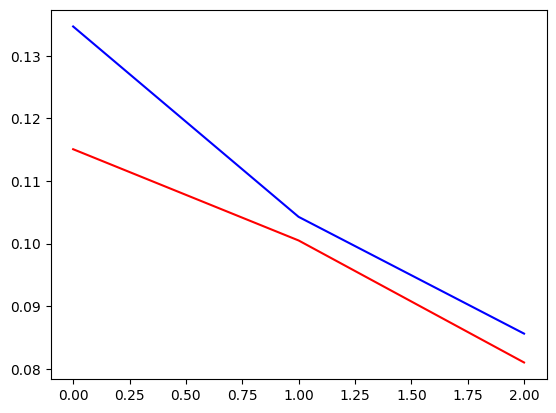

Loss Diff -0.009328469469771103
Training transfer_neuMF_f_model ...

 Training epoch 0
-- train loss 0.0929

 epoch 0
-- train loss 0.0929, validation loss 0.0858
HR: 0.507	NDCG: 0.282

 Training epoch 1
-- train loss 0.0856
HR: 0.504	NDCG: 0.280

 Training epoch 2
-- train loss 0.0855
HR: 0.502	NDCG: 0.279

 Training epoch 3
-- train loss 0.0855
HR: 0.506	NDCG: 0.280

 Training epoch 4
-- train loss 0.0855
HR: 0.504	NDCG: 0.280

 Training epoch 5
-- train loss 0.0854

 epoch 5
-- train loss 0.0854, validation loss 0.0855
HR: 0.501	NDCG: 0.279

 Training epoch 6
-- train loss 0.0855
HR: 0.501	NDCG: 0.279

 Training epoch 7
-- train loss 0.0854
HR: 0.507	NDCG: 0.281

 Training epoch 8
-- train loss 0.0855
HR: 0.501	NDCG: 0.279

 Training epoch 9
-- train loss 0.0854
HR: 0.504	NDCG: 0.279

 Training epoch 10
-- train loss 0.0854

 epoch 10
-- train loss 0.0854, validation loss 0.0854
HR: 0.507	NDCG: 0.281

 Training epoch 11
-- train loss 0.0854
HR: 0.506	NDCG: 0.278

 Training epoch 12


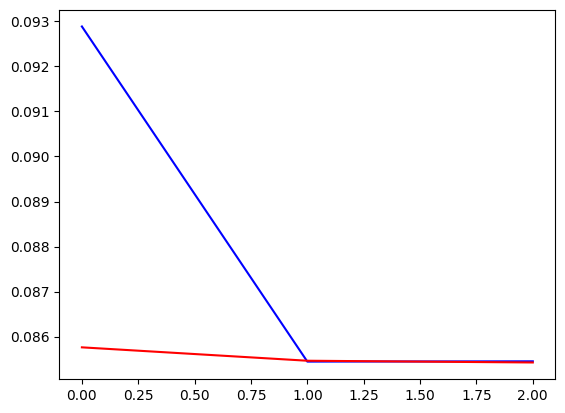

Loss Diff -0.0023782321154865865


In [ ]:
#model_dict = {'model': model}
args = parser.parse_args("")


for model in model_dicts.keys():
  print('Training {} ...'.format(model))
  criterion = nn.MSELoss(reduction = 'mean')
  optimizer = torch.optim.Adam(model_dicts[model].parameters(), lr=args.lr)

  tr_loss, va_loss = [], []

  for epoch in range(args.epochs):
    print(f'\n Training epoch {epoch}')
    tr_loss_step = training_step(model_dicts[model], criterion = criterion, optimizer = optimizer)
    print(f'-- train loss {tr_loss_step:.3}')
    if epoch % 5 == 0:
      va_loss_step = validation_step(model_dicts[model], criterion = criterion, optimizer = optimizer)
      va_loss.append(va_loss_step)
      tr_loss.append(tr_loss_step)
      print(f'\n epoch {epoch}')
      print(f'-- train loss {tr_loss_step:.3}, validation loss {va_loss_step:.3}')
    HR, NDCG = metrics(model_dicts[model], test_loader, args.top_k, device)
    print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))


  plot_loss(tr_loss, va_loss)
  loss_diff = np.array(va_loss)- np.array(tr_loss)
  print('Loss Diff', np.mean(loss_diff[-10:]))

Performance Check

The network which has been trained from scratch took 15 epoch of training and still gave a hit ratio of 0.498 and an NDCG(Normalized Distributed Cumulative Gain) of 0.276, while the network which already had the pre-learned free parameters gave a hit ratio of 0.507 and NDCG of 0.28 right in the first Epoch, which clearly shows the advantage of Transfer Learning.

However, as seen in case of prelearned model, the training loss seems to be saturated after few epochs, since learning has already been done in the initial few epochs and after that nothing new is being learnt with every ongoing epoch.

Thus, we can get the desired putput with fewer epoch.